In [140]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
# theme = A Deep Learning Framework based on Random Forest and data augmentation for lameness prediction in dairy cattle
# tools = Python, Numpy, Pandas, Keras, Tensorflow, Sklearn and Matplotlib
# author = Dylan Lebatteux
# date = 22/09/21

In [2]:
###############
### Imports ###
###############
import os
import csv
import math
import random
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

In [4]:
###########################
### Basic configuration ###
###########################

# Ignore warnings about deprecated features
warnings.simplefilter(action = "ignore")

In [5]:
############################################
#### Generation of the score dictionary  ### 
############################################

# Initialize the score dictionary
scores = {}
# Opening the score csv file
with open("scores.csv", mode = "r", encoding = "utf-8-sig") as file:
  # Reading the csv file
  scoreFile = csv.reader(file, delimiter = ";")
  # Save the contents of the CSV file
  for lines in scoreFile: 
    id = lines[0]
    score = lines[1]
    scores[id] = score

In [6]:
######################################################
### Generation of the locomotion matrix dictionary ###
######################################################

# Get the list of locomotion data files 
listLocomotionData = os.listdir("Locomotion")

# Initialize the data dictionary
data = {}
# Get the list of sensor names
sensor_names = pd.read_excel("Locomotion/" + listLocomotionData[0]).columns

# Iterate through the score dictionary
for key, value in scores.items(): 
  # Iterate through the list of locomotion data files 
  for locomotion in listLocomotionData: 
    if key in locomotion:
      df = pd.read_excel ("Locomotion/" + locomotion)
      df = df.dropna(how = "all")
      df = df.fillna(0)
      df = df.to_numpy()
      data[key] = df

In [7]:
######################################
### Set dimensions of the matrices ###
######################################

# Initialize the number of rows and columns
n_rows = []
n_columns = 60

# Iterate through the data dictionary
for key, value in data.items(): 
  # Save the number of rows of the actual array
  n_rows.append(value.shape[0])
# Set the number of rows for all arrays with he minimal value
n_rows = max(n_rows)
# Print the number of rows and columns
print("COLUMNS:", n_columns, "ROWS:", n_rows)

COLUMNS: 60 ROWS: 502


In [8]:
#############################################################
### Generation of matrices and imputation of missing data ###
#############################################################

# Initialize the feature matrix and the class vector
X = []
y = []

# Iterate through the data dictionary
for key, value in data.items():
  # Build the features matrix
  if scores[key] == "2" or scores[key] == "2,5" or scores[key] == "3" or scores[key] == "3,5":
    x = []
    for i in range(n_columns):
      for j in range(n_rows):
        try: x.append(float(value[j][i]))
        except:x.append(float(0))
    x = np.array(x)
    X.append(x)
      
    # Save the classes
    if scores[key] == "2": y.append(0)
    elif scores[key] == "2,5":y.append(1)
    elif scores[key] == "3":y.append(2)
    elif scores[key] == "3,5" :y.append(3)
    else: pass

# Data scaling
minMaxScaler = MinMaxScaler()
minMaxScaler.fit(X)
X = minMaxScaler.transform(X)

# Transform the matrix avec vector to numpy array
X = np.array(X)
y = np.array(y)

In [9]:
#####################################
### Display the data informations ###
#####################################
print("Matrice:", X.shape)
print("Classes:", set(y))
print("Example of instance:", X[0])

Matrice: (74, 30120)
Classes: {0, 1, 2, 3}
Example of instance: [1. 1. 1. ... 0. 0. 0.]


In [10]:
#################################
### Perform data augmentation ###
#################################

# Initialize the feature matrix and the class vector for generated data
X_Generated = []
y_Generated = []

# Set the variables
variation_percentage = 5

# Iterate through the instances of X_Deep
for i, x in enumerate(X):

    # Set the number of instance to generate balanced dataset
    if y[i] == 0: n_generated_instances = 125
    if y[i] == 1: n_generated_instances = 84
    if y[i] == 2: n_generated_instances = 132
    if y[i] == 3: n_generated_instances = 500
    
    # Iterate through the inumber of instances to generate
    for j in range(int(n_generated_instances)):
        # Initialize the vector to save the new matrix
        x_Generated = []
        # Iterate through the row of the actual instance
        for value in x:
            # Generate random variation for the instance
            random_number = random.random() * variation_percentage / 100
            # Generate boolen to add or remove the variation
            boolean = random.randint(0 , 1)
            # Save value adding variation
            if boolean == 0: x_Generated.append(value + value * random_number)
            # Save value removing variation
            else: x_Generated.append(value - value * random_number)
        # Covert the matrix vector to numpy matrix
        x_Generated = np.array(x_Generated)
        # Save the generated matrix
        X_Generated.append(x_Generated)
        # Save the associated classes
        y_Generated.append(y[i])

# Transform the matrix avec vector to numpy array
X_Generated = np.array(X_Generated)
y_Generated = np.array(y_Generated)

In [12]:
#####################################
### Display the data informations ###
#####################################
print("Matrice:", X_Generated.shape)
print("Classes:", set(y_Generated))
print("Example of instance:", X_Generated[0])

Matrice: (10028, 30120)
Classes: {0, 1, 2, 3}
Example of instance: [0.95915548 1.00054258 1.00969061 ... 0.         0.         0.        ]


In [13]:
#################################
### Generate Train/Test Split ###
#################################
X_train, X_test, y_train, y_test = train_test_split(X_Generated, y_Generated, test_size = 0.20, random_state = 42)
print("X_train shape =", X_train.shape)
print("X_test shape =", X_test.shape)

X_train shape = (8022, 30120)
X_test shape = (2006, 30120)


In [14]:
#################################
### Random Forest Model Train ###
#################################
model = RandomForestClassifier(n_estimators = 100, criterion='gini', max_depth=None, bootstrap=True, n_jobs=-1,  random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [157]:
######################################
### Random Forest Model Evaluation ###
######################################
stratifiedKFold = StratifiedKFold(n_splits = 10, random_state = 1, shuffle = True)
y_pred = cross_val_predict(model, X_train, y_train, n_jobs = 10, cv = stratifiedKFold)
print("\nClassification report:\n", classification_report(y_train, y_pred, digits = 3))


Classification report:
               precision    recall  f1-score   support

           0      1.000     1.000     1.000      1976
           1      1.000     1.000     1.000      2013
           2      1.000     1.000     1.000      1985
           3      1.000     1.000     1.000      2048

    accuracy                          1.000      8022
   macro avg      1.000     1.000     1.000      8022
weighted avg      1.000     1.000     1.000      8022



In [15]:
######################################
### Random Forest Model Prediction ###
######################################
y_pred = model.predict(X_test)
print("Classification report \n", classification_report(y_test, y_pred, digits=3))

Classification report 
               precision    recall  f1-score   support

           0      1.000     1.000     1.000       524
           1      1.000     1.000     1.000       507
           2      1.000     1.000     1.000       523
           3      1.000     1.000     1.000       452

    accuracy                          1.000      2006
   macro avg      1.000     1.000     1.000      2006
weighted avg      1.000     1.000     1.000      2006



In [16]:
#################################
### Get the 10 best features  ###
#################################
k = 10
indices = np.argsort(model.feature_importances_)[::-1]
top_k_indices = indices[:k]
print(top_k_indices)

[  751  7609  7336  7333  8853  7334 28686  7332  8336  1262]


In [17]:
######################################
### Random Forest Model Prediction ###
######################################
model.fit(X_train[:,top_k_indices], y_train)
y_pred = model.predict(X_test[:,top_k_indices])
print("Classification report \n", classification_report(y_test, y_pred, digits=3))

Classification report 
               precision    recall  f1-score   support

           0      0.972     0.990     0.981       524
           1      0.988     0.943     0.965       507
           2      0.961     0.985     0.973       523
           3      1.000     1.000     1.000       452

    accuracy                          0.979      2006
   macro avg      0.980     0.979     0.980      2006
weighted avg      0.979     0.979     0.979      2006



In [18]:
##################################################
### Identifies the best feature correspondence ###
##################################################
for i in top_k_indices: 
    sensor = math.floor(i / 502)
    while i > 502: i = i -502
    print("Sensor " + str(sensor_names[sensor]), "(" + str(sensor) + ")," + " value: " + str(i))

Sensor Y-RFH (1), value: 249
Sensor X-RRF (15), value: 79
Sensor Z-RRH (14), value: 308
Sensor Z-RRH (14), value: 305
Sensor Z-RRF (17), value: 319
Sensor Z-RRH (14), value: 306
Sensor X-B4 (57), value: 72
Sensor Z-RRH (14), value: 304
Sensor Y-RRF (16), value: 304
Sensor Z-RFH (2), value: 258


In [19]:
############################################################
### Function to draw the plot of the data representation ###
############################################################

# Define the function to draw Scatter Plot
def generateScatterPlot(title, X_transformed, y_transformed, targets):
    # Define the figure and the axes
    fig = plt.figure(figsize=(15, 10))
    ax = Axes3D(fig)
    # List of colors
    colors = ["tab:blue", "tab:orange", "tab:green", "tab:red"]
    # Iterate through the targets
    for i, target in enumerate(targets):
        # Set the list of axis positions
        ax_x = []
        ax_y = []
        ax_z = []
        # Set the color
        color = colors[i]
        # Iterate through the data
        for i, d in enumerate(X_transformed):
            # If the sequence belongs to the target of interest
            if y_transformed[i] == target:
                # Save the values
                ax_x.append(X_transformed[i][0])
                ax_y.append(X_transformed[i][1])
                ax_z.append(X_transformed[i][2])
        # Add the current scatter plot to the figure
        ax.scatter(ax_x, ax_y, ax_z, c = color, label = target, alpha = 0.75, edgecolors = 'none')
    # Display the grid
    ax.grid(True)
    # Set the legend parameters
    ax.legend(loc = 2, prop = {'size': 10})
    # Set the tite
    plt.title(title)
    # Set axes labels
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')
    # Displqy the figure
    plt.show()

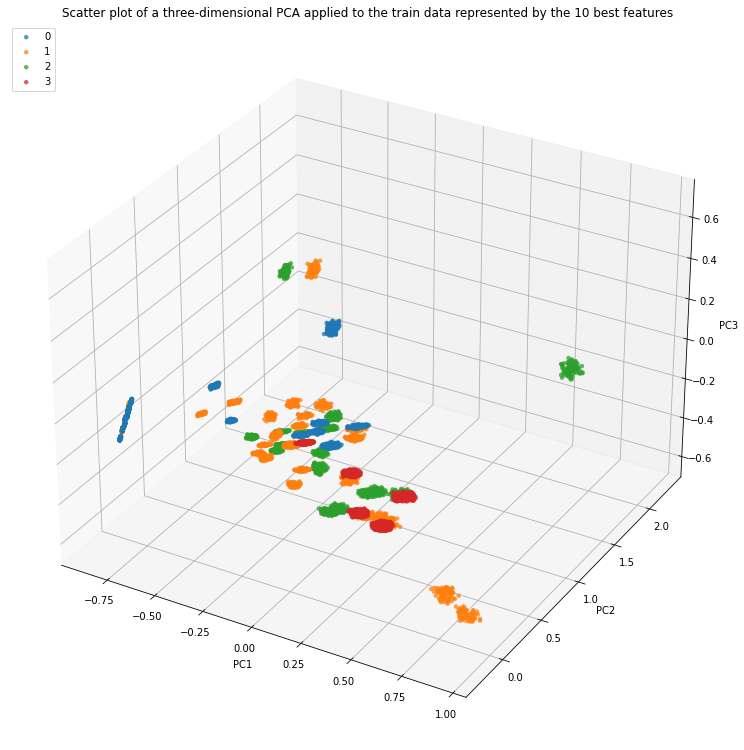

In [20]:
###################################################################################
### Apply a pca to transform the train data represented by the 10 best features ###
###################################################################################
pca = PCA(n_components = 3)
X_pca =  pca.fit_transform(X_train[:,top_k_indices])
generateScatterPlot(title= "Scatter plot of a three-dimensional PCA applied to the train data represented by the 10 best features", X_transformed = X_pca, y_transformed= y_train, targets = set(y_train))

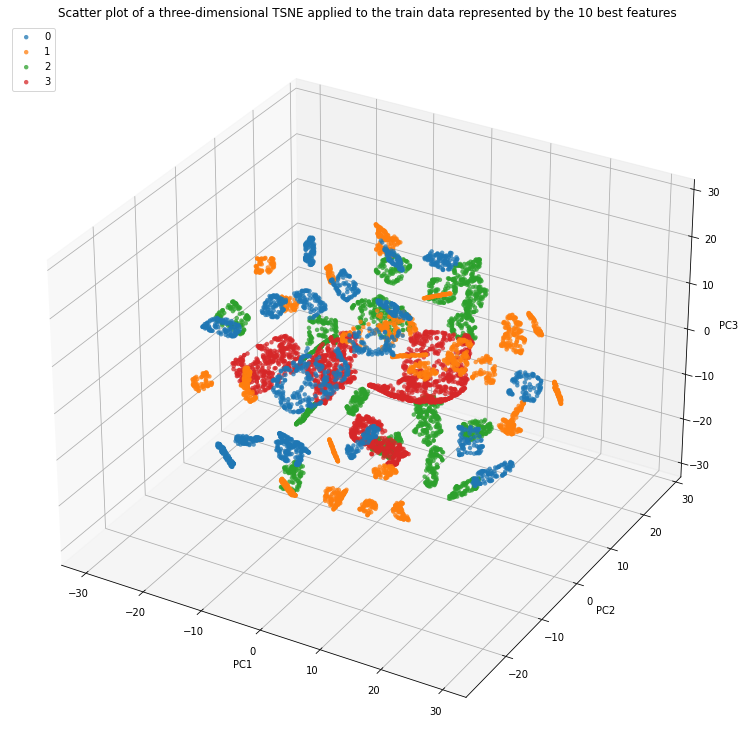

In [21]:
tsne = TSNE(n_components = 3, random_state = 0)
X_TSNE = tsne.fit_transform(X_train[:,top_k_indices])
generateScatterPlot(title= "Scatter plot of a three-dimensional TSNE applied to the train data represented by the 10 best features", X_transformed = X_TSNE, y_transformed= y_train, targets = set(y_train))